<a href="https://colab.research.google.com/github/nyck33/reinforcement-learning/blob/master/cartpole_dqn_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_50 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_51 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_53 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_54 (De

SystemExit: ignored

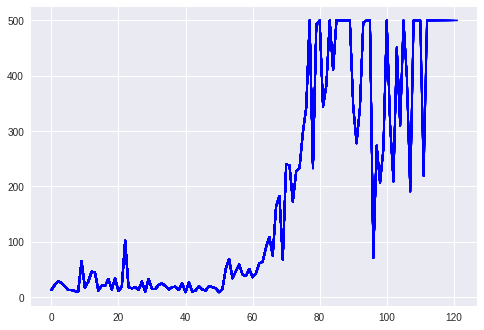

In [10]:
import sys
import gym
import pylab
import random
import numpy as np
import datetime
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
'''
###for Tensorboard
from keras.callbacks import TensorBoard
import tensorflow as tf

###
log_filepath='./log'
'''
EPISODES = 1000


# DQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and replay memory & target q network
class DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        #Tried to change the way epsilon is calculated per Q-learning-cart.ipynb but doesn't work here
        #although epsilon has a gradual decline for this game we want a fast transition from explore to exploit
        #self.epsilon_start = 1.0
        self.epsilon = 1 #0
        self.epsilon_decay = 0.999 #0.0001
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model with same weights as the model, in case we load a model
        #shouldn't this be done after load_model?
        self.update_target_model()

        if self.load_model:
            self.model.load_weights("./save_model/cartpole_dqn.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network, ie. no softmax
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform')) #std distribution from [-limit, limit], limit=sqrt(6/num input units in weight tensor)
        model.add(Dense(24, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', #TODO: defind activation: why linear?
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate)) #TODO: deine loss function mse


        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def get_action(self, state, step): #don't need step parameter
        #TODO: check epsilon greedy formula
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else: #exploit more later
            q_value = self.model.predict(state)
            #return the max of 0.51 or 0.49, R or L
            return np.argmax(q_value[0]) 

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done, step):
        self.memory.append((state, action, reward, next_state, done))
        #if epsilon has not reached min and we are done filling memory
        if (self.epsilon > self.epsilon_min) and (len(self.memory) >= self.train_start):
            self.epsilon *= self.epsilon_decay

    #don't train until memory 1000
    def train_model(self):
        if len(self.memory) < self.train_start:
            return
        if (len(self.memory)==(self.train_start)): #just checking that epsilon did not change
            print("\n\nself.epsilon", self.epsilon)
        batch_size = min(self.batch_size, len(self.memory))
        #sample from memory, batch_size of 64
        mini_batch = random.sample(self.memory, batch_size)
        #print("\n\n mini_batch", mini_batch)

        #initialize these arrays
        update_input = np.zeros((batch_size, self.state_size)) #np array for the state value
        update_target = np.zeros((batch_size, self.state_size)) #np array for target state value
        action, reward, done = [], [], [] #create empty lists

        #from batch_size of 64, fill the arrays
        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0] #state
            action.append(mini_batch[i][1]) #action
            reward.append(mini_batch[i][2]) #reward
            update_target[i] = mini_batch[i][3] #next_state
            done.append(mini_batch[i][4]) #done
    ##########################################################################
        #print("\n\nupdate_input", update_input)
        #print("\n\naction", action)
        #print("\n\nreward", reward)
        #print("\n\nupdate_target", update_target)

        #returns array of Q-values for R and L for each state samples
        target = self.model.predict(update_input)
        #print("\n\ntarget", target)
        #returns array of Q-values for R and L for each target next_state
        target_val = self.target_model.predict(update_target)
        #print("\n\ntarget_val", target_val)

        #iterate 64 times
        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i] #Q value is the reward if done
                #print("\n\ntarget[{}][action[{}] ".format(i, i), target[i][action[i]])
            else:

                target[i][action[i]] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))
                #print("\n\ntarget[{}][action[{}] ".format(i, i), target[i][action[i]])

        #print("\n\ntarget\n\n{}\n\n".format(target))

        ###add for Tensorboard
        #log_name = "Foo_{}".format(datetime.datetime.now().isoformat(timespec='seconds')).replace(':', '-')
        #tensorboard = TensorBoard(log_dir="log/", histogram_freq=1, write_graph=True,
                                 # write_images=False)
        ###
        # gradient descent, train data state on labels target for batch_size
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0) #callbacks=[tensorboard])




if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    env = gym.make('CartPole-v1')
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n


    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size]) #reshape state into array of one row and state_size num cols
        steps = 0 #up to 500

        while not done:
            if agent.render: #if True
                env.render()
            steps+=1
            # get e greedy action
            action = agent.get_action(state, steps)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100 #if done, -100. 499 ensures -100 doesn't occur after completion of 500
            #-100 is a big punishment for falling since rewards are small and cumulative through 500 steps
            # save <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done, steps)
            # every time step do the training, won't start real until deque is at least training_start or 1000 full
            agent.train_model()
            score += reward
            state = next_state #updated state

            if done:
                # every episode update the target model to be same with model (donkey and carrot), carries over to next episdoe
                agent.update_target_model()

                # every episode, plot the play time, score= total_rewards
                score = score if score == 500 else score + 100 #if done, give back the 100 that was taken away when appending rewards above
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b') #'b' is type of marking for plot
                #pylab.show()
                #pylab.savefig("./save_graph/") #cartpole_dqn.png
                if(e % 1 == 0):
                    print("episode:", e, "  score:", score, "  memory length:",
                        len(agent.memory), "  epsilon:", agent.epsilon)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    sys.exit()

        # save the model every 50th episode
        #if e % 50 == 0:
         #   agent.model.save_weights("./save_model/cartpole_dqn.h5")


episode 0 reward 11.0
episode 1 reward 19.0
episode 2 reward 17.0
episode 3 reward 20.0
episode 4 reward 16.0
episode 5 reward 17.0
episode 6 reward 19.0
episode 7 reward 10.0
episode 8 reward 73.0
episode 9 reward 11.0
episode 10 reward 21.0
episode 11 reward 11.0
episode 12 reward 21.0
episode 13 reward 12.0
episode 14 reward 14.0
episode 15 reward 39.0
episode 16 reward 21.0
episode 17 reward 15.0
episode 18 reward 17.0
episode 19 reward 22.0
episode 20 reward 44.0
episode 21 reward 20.0
episode 22 reward 9.0
episode 23 reward 21.0
episode 24 reward 13.0
episode 25 reward 14.0
episode 26 reward 10.0
episode 27 reward 9.0
episode 28 reward 34.0
episode 29 reward 26.0
episode 30 reward 66.0
episode 31 reward 11.0
episode 32 reward 11.0
episode 33 reward 17.0
episode 34 reward 13.0
episode 35 reward 39.0
episode 36 reward 34.0
episode 37 reward 19.0
episode 38 reward 39.0
episode 39 reward 24.0
episode 40 reward 17.0
episode 41 reward 9.0
episode 42 reward 30.0
episode 43 reward 15.0
e

SystemExit: ignored

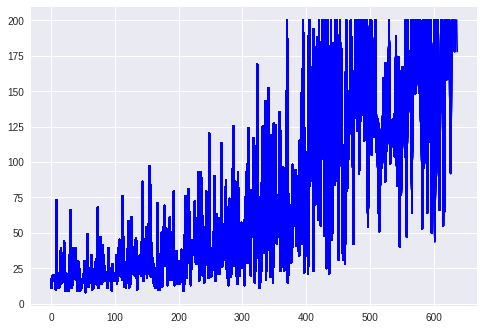

In [15]:
"""
Simple policy gradient in Keras

"""
import gym
import numpy as np

from keras import layers
from keras.models import Model
from keras import backend as K
from keras import utils as np_utils
from keras import optimizers


class Agent(object):

    def __init__(self, input_dim, output_dim, hidden_dims=[32, 32]):
        """Gym Playing Agent

        Args:
            input_dim (int): the dimension of state.
                Same as `env.observation_space.shape[0]`

            output_dim (int): the number of discrete actions
                Same as `env.action_space.n`

            hidden_dims (list): hidden dimensions

        Methods:

            private:
                __build_train_fn -> None
                    It creates a train function
                    It's similar to defining `train_op` in Tensorflow
                __build_network -> None
                    It create a base model
                    Its output is each action probability

            public:
                get_action(state) -> action
                fit(state, action, reward) -> None
        """

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.__build_network(input_dim, output_dim, hidden_dims)
        self.__build_train_fn()

    def __build_network(self, input_dim, output_dim, hidden_dims=[32, 32]):
        """Create a base network"""
        self.X = layers.Input(shape=(input_dim,))
        net = self.X

        for h_dim in hidden_dims:
            net = layers.Dense(h_dim)(net)
            net = layers.Activation("relu")(net)

        net = layers.Dense(output_dim)(net)
        net = layers.Activation("softmax")(net)

        self.model = Model(inputs=self.X, outputs=net)

    def __build_train_fn(self):
        """Create a train function

        It replaces `model.fit(X, y)` because we use the output of model and use it for training.

        For example, we need action placeholder
        called `action_one_hot` that stores, which action we took at state `s`.
        Hence, we can update the same action.

        This function will create
        `self.train_fn([state, action_one_hot, discount_reward])`
        which would train the model.

        """
        action_prob_placeholder = self.model.output
        action_onehot_placeholder = K.placeholder(shape=(None, self.output_dim),
                                                  name="action_onehot")
        discount_reward_placeholder = K.placeholder(shape=(None,),
                                                    name="discount_reward")

        action_prob = K.sum(action_prob_placeholder * action_onehot_placeholder, axis=1)
        log_action_prob = K.log(action_prob)

        loss = - log_action_prob * discount_reward_placeholder
        loss = K.mean(loss)

        adam = optimizers.Adam()

        updates = adam.get_updates(params=self.model.trainable_weights, loss=loss)

        self.train_fn = K.function(inputs=[self.model.input,
                                           action_onehot_placeholder,
                                           discount_reward_placeholder],
                                   outputs=[],
                                   updates=updates)

    def get_action(self, state):
        """Returns an action at given `state`

        Args:
            state (1-D or 2-D Array): It can be either 1-D array of shape (state_dimension, )
                or 2-D array shape of (n_samples, state_dimension)

        Returns:
            action: an integer action value ranging from 0 to (n_actions - 1)
        """
        shape = state.shape

        if len(shape) == 1:
            assert shape == (self.input_dim,), "{} != {}".format(shape, self.input_dim)
            state = np.expand_dims(state, axis=0)

        elif len(shape) == 2:
            assert shape[1] == (self.input_dim), "{} != {}".format(shape, self.input_dim)

        else:
            raise TypeError("Wrong state shape is given: {}".format(state.shape))

        action_prob = np.squeeze(self.model.predict(state))
        assert len(action_prob) == self.output_dim, "{} != {}".format(len(action_prob), self.output_dim)
        return np.random.choice(np.arange(self.output_dim), p=action_prob)

    def fit(self, S, A, R):
        """Train a network

        Args:
            S (2-D Array): `state` array of shape (n_samples, state_dimension)
            A (1-D Array): `action` array of shape (n_samples,)
                It's simply a list of int that stores which actions the agent chose
            R (1-D Array): `reward` array of shape (n_samples,)
                A reward is given after each action.

        """
        action_onehot = np_utils.to_categorical(A, num_classes=self.output_dim)
        discount_reward = compute_discounted_R(R)

        assert S.shape[1] == self.input_dim, "{} != {}".format(S.shape[1], self.input_dim)
        assert action_onehot.shape[0] == S.shape[0], "{} != {}".format(action_onehot.shape[0], S.shape[0])
        assert action_onehot.shape[1] == self.output_dim, "{} != {}".format(action_onehot.shape[1], self.output_dim)
        assert len(discount_reward.shape) == 1, "{} != 1".format(len(discount_reward.shape))

        self.train_fn([S, action_onehot, discount_reward])


def compute_discounted_R(R, discount_rate=.99):
    """Returns discounted rewards

    Args:
        R (1-D array): a list of `reward` at each time step
        discount_rate (float): Will discount the future value by this rate

    Returns:
        discounted_r (1-D array): same shape as input `R`
            but the values are discounted

    Examples:
        >>> R = [1, 1, 1]
        >>> compute_discounted_R(R, .99) # before normalization
        [1 + 0.99 + 0.99**2, 1 + 0.99, 1]
    """
    discounted_r = np.zeros_like(R, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(R))):

        running_add = running_add * discount_rate + R[t]
        discounted_r[t] = running_add

    discounted_r -= discounted_r.mean() / discounted_r.std()

    return discounted_r


def run_episode(env, agent):
    """Returns an episode reward

    (1) Play until the game is done
    (2) The agent will choose an action according to the policy
    (3) When it's done, it will train from the game play

    Args:
        env (gym.env): Gym environment
        agent (Agent): Game Playing Agent

    Returns:
        total_reward (int): total reward earned during the whole episode
    """
    done = False
    S = []
    A = []
    R = []

    s = env.reset()

    total_reward = 0

    while not done:

        a = agent.get_action(s)

        s2, r, done, info = env.step(a)
        total_reward += r

        S.append(s)
        A.append(a)
        R.append(r)

        s = s2

        if done:
            S = np.array(S)
            A = np.array(A)
            R = np.array(R)

            agent.fit(S, A, R)

    return total_reward


def main():
    try:
        env = gym.make("CartPole-v0")
        input_dim = env.observation_space.shape[0]
        output_dim = env.action_space.n
        agent = Agent(input_dim, output_dim, [16, 16])
        
        scores, episodes = [], []
        for episode in range(2000):
            reward = run_episode(env, agent)
            scores.append(reward)
            episodes.append(episode)
            pylab.plot(episodes, scores, 'b') #'b' is type of marking for plot
            print("episode {} reward {}".format(episode, reward))
            # if the mean of scores of last 10 episode is bigger than 190
            # stop training
            if np.mean(scores[-min(10, len(scores)):]) > 190:
              sys.exit()

    finally:
        env.close()


if __name__ == '__main__':
    main()